# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)

In [3]:
dfs = pd.read_html(response.text)
df = dfs[0]

/tmp/ipykernel_6630/1729118732.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(response.text)


In [5]:
df.columns = ['Rank', 'Song', 'Artist', 'Streams_Billions', 'Release_Date', 'Notes']
df.columns

Index(['Rank', 'Song', 'Artist', 'Streams_Billions', 'Release_Date', 'Notes'], dtype='object')

In [6]:
df['Streams_Billions'] = df['Streams_Billions'].astype(str).str.replace(r'\[.*?\]', '', regex=True)
df['Streams_Billions'] = pd.to_numeric(df['Streams_Billions'], errors='coerce')
df['Release_Year'] = df['Release_Date'].astype(str).str.extract(r'(\d{4})').astype(float)
df.dropna(subset=['Song', 'Artist', 'Streams_Billions', 'Release_Year'], inplace=True)
df_final = df[['Song', 'Artist', 'Streams_Billions', 'Release_Year']].copy()
df_final.rename(columns={'Streams_Billions': 'Streams'}, inplace=True)

In [9]:
df_final

,Song,Artist,Streams,Release_Year
0,"""Blinding Lights""",The Weeknd,4.836,2019.0
1,"""Shape of You""",Ed Sheeran,4.357,2017.0
2,"""Someone You Loved""",Lewis Capaldi,3.901,2018.0
3,"""Starboy""",The Weeknd and Daft Punk,3.889,2016.0
4,"""As It Was""",Harry Styles,3.873,2022.0
...,...,...,...,...
95,"""Too Good at Goodbyes""",Sam Smith,2.302,2017.0
96,"""Stay with Me""",Sam Smith,2.292,2014.0
97,"""Someone Like You""",Adele,2.290,2011.0
98,"""Havana""",Camila Cabello and Young Thug,2.281,2017.0


In [7]:
con = sqlite3.connect('canciones_spotify.db')
df_final.to_sql('most_streamed_songs', con, if_exists='replace', index=False)
con.close()

/tmp/ipykernel_6630/1559734486.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Streams', y='Song', data=top_10_canciones, palette='viridis')


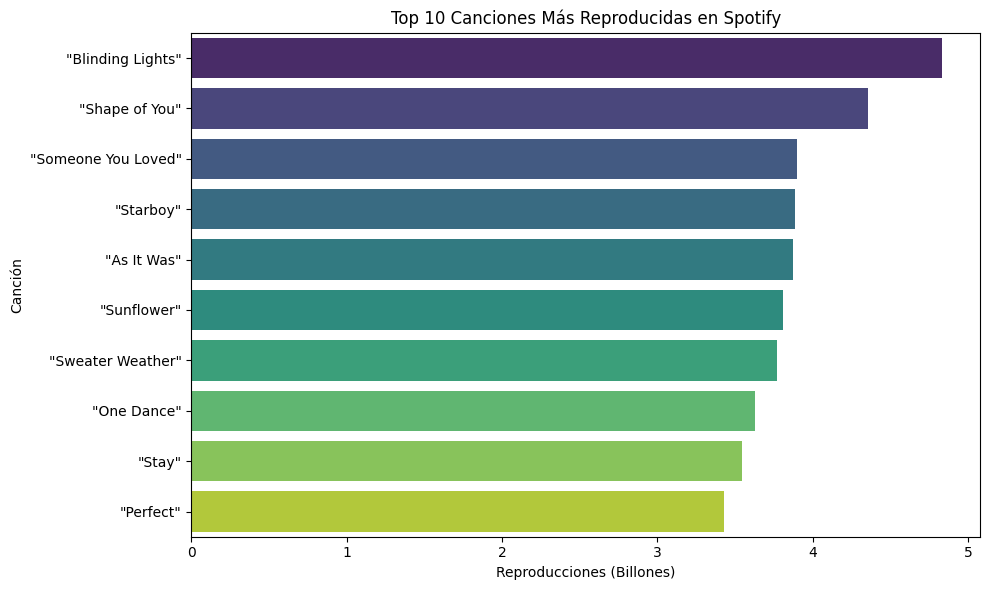

In [12]:
con = sqlite3.connect('canciones_spotify.db')
df_visualizaciones = pd.read_sql_query("SELECT * FROM most_streamed_songs", con)
con.close()

# Visualización 1: Top 10 Canciones por Reproducciones
plt.figure(figsize=(10, 6))
top_10_canciones = df_visualizaciones.nlargest(10, 'Streams')
sns.barplot(x='Streams', y='Song', data=top_10_canciones, palette='viridis')
plt.title('Top 10 Canciones Más Reproducidas en Spotify')
plt.xlabel('Reproducciones (Billones)')
plt.ylabel('Canción')
plt.tight_layout()
plt.show()

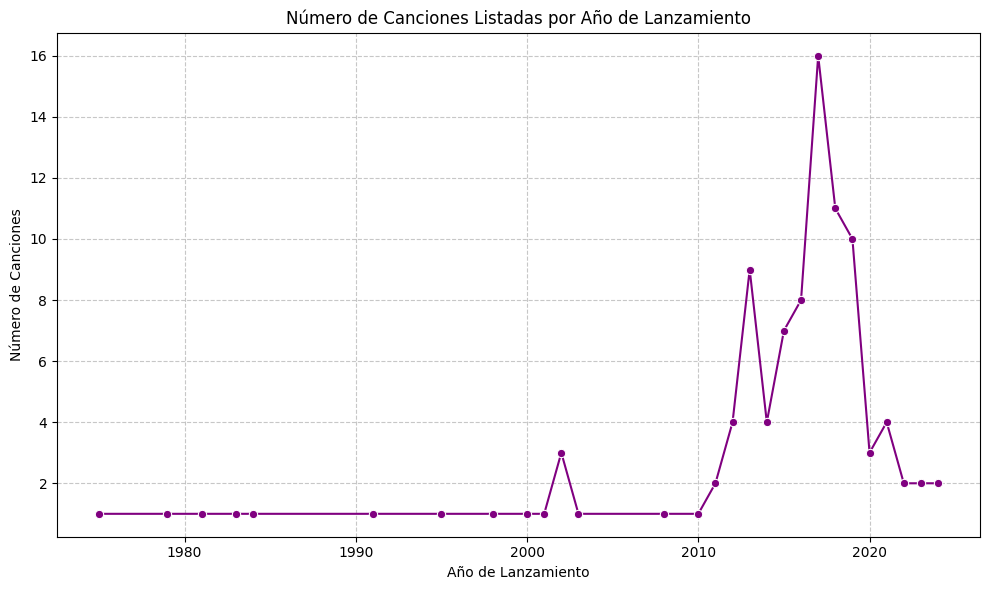

In [13]:
# Visualización 2: Número de canciones por Año de Lanzamiento
plt.figure(figsize=(10, 6))
songs_per_year = df_visualizaciones.groupby('Release_Year').size().reset_index(name='Count')
sns.lineplot(x='Release_Year', y='Count', data=songs_per_year, marker='o', color='purple')
plt.title('Número de Canciones Listadas por Año de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Número de Canciones')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

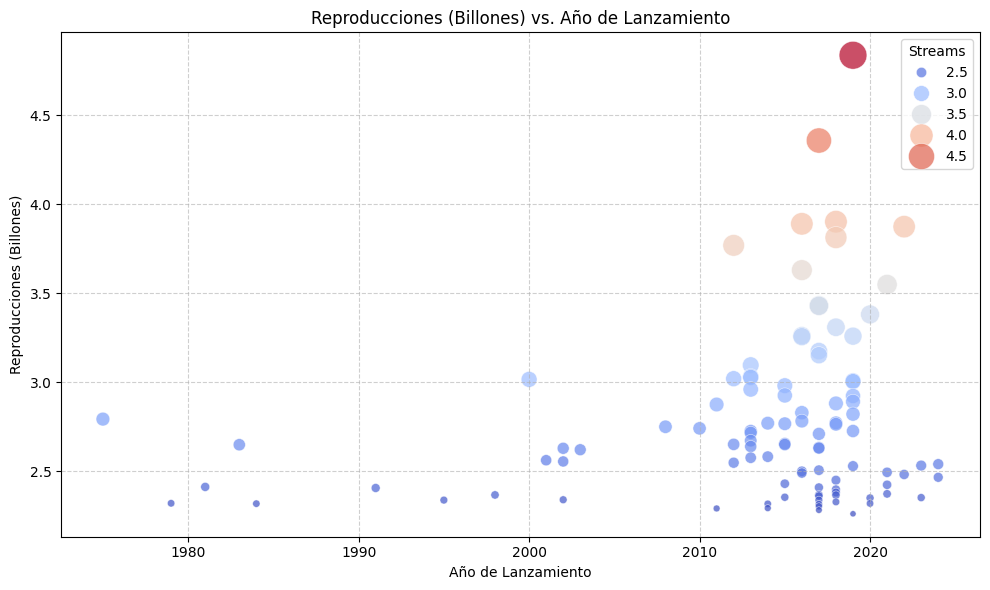

In [11]:
# Visualización 3: Dispersión de Reproducciones vs. Año de Lanzamiento
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Release_Year', y='Streams', data=df_visualizaciones, alpha=0.7, hue='Streams', size='Streams', sizes=(20, 400), palette='coolwarm', legend='brief')
plt.title('Reproducciones (Billones) vs. Año de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Reproducciones (Billones)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()